# Seasonal flu vaccines
This exericse predicts whether individuals will receive their seasonal flu vaccines by fitting machine learning models to the U.S. National 2009 H1N1 Flu Survey data. Data is provided courtesy of the United States National Center for Health Statistics to DrivenData for a practice competition (https://www.drivendata.org/competitions/66/flu-shot-learning/).

In [131]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

#support vector classifier
from sklearn.svm import SVC

#random forest classifier
from sklearn.ensemble import RandomForestClassifier

#deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dropout

#performance metrics
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

In [132]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data checking and cleaning
In this section, read the csv files into pandas Dataframe and perform any necessary checking and cleaning steps. 

In [133]:
#reading training_set_labels 
df_labels = pd.read_csv("./Resources/training_set_labels.csv", index_col = "respondent_id")
df_labels.head(3)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0


In [134]:
#reading training_set_features
df_features = pd.read_csv("./Resources/training_set_features.csv", index_col = "respondent_id")
df_features.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [135]:
#combine both dataframes into a single dataframe
df_vaccine = pd.concat([df_labels,df_features],axis = 1)
df_vaccine.head(3)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [136]:
#identify h1n1 specific columns
h1n1 = df_vaccine.filter(like = "h1n1").columns
display(h1n1)

#drop h1n1 specific data
df_vaccine.drop(columns = h1n1, inplace = True)

Index(['h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc'],
      dtype='object')

In [137]:
#check for missing values
df_vaccine.isnull().sum()

seasonal_vaccine                   0
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
h

In [138]:
#drop columns with more than 40% missing value
df_vaccine.drop(columns = ["health_insurance","employment_industry","employment_occupation"], inplace= True)

In [139]:
df_vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   seasonal_vaccine             26707 non-null  int64  
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_seasonal         24547 non-null  float64
 9   chronic_med_condition        25736 non-null  float64
 10  child_under_6_months         25887 non-null  float64
 11  health_worker                25903 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

## Data Preprocessing
**Review the DataFrame, looking for categorical variables that will need to be encoded, as well as columns that could eventually define your features and target variables.**

In [140]:
df_features = df_vaccine.drop(columns = ["seasonal_vaccine"]).copy()
df_features.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0


In [141]:
# Create and display the list of numerical variables 
numerical_variables = list(df_features.dtypes[df_features.dtypes != "object"].index)
numerical_variables

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [142]:
# Create a list of categorical variables 
categorical_variables = list(df_features.dtypes[df_features.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

**Replacing missing values with most frequent value**

In [143]:
#define strategy for replacing missing values
imp_mostfreq = SimpleImputer(strategy = "most_frequent", missing_values = np.nan)

In [144]:
#replacing missing values
df_numerical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[numerical_variables].loc[:,:]),
                                   columns = df_features[numerical_variables].columns)

df_numerical_variables_imputed.head()

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0


In [145]:
#replacing missing values
df_categorical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[categorical_variables].loc[:,:]),
                                   columns = df_features[categorical_variables].columns)

df_categorical_variables_imputed.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


**Encode the dataset’s categorical variables using OneHotEncoder, and then place the encoded variables into a new DataFrame.**

In [146]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse = False)

In [147]:
# Encode the categorcal variables using OneHotEncoder
encoded_data = enc.fit_transform(df_categorical_variables_imputed)

In [148]:
# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data,
                          columns = enc.get_feature_names_out(categorical_variables)
                         )

# Review the DataFrame
encoded_df.head()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


**Add the original DataFrame’s numerical variables to the DataFrame containing the encoded variables.**

In [149]:
# Add the numerical variables from the original DataFrame to the one-hot encoding DataFrame
encoded_df = pd.concat([encoded_df, df_numerical_variables_imputed], axis = 1)

# Review the Dataframe
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


**Define features and target variables**

In [150]:
#define features set X
X = encoded_df.copy()

# Review the features DataFrame
X.head()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0


In [151]:
#define target variable y
y = df_vaccine["seasonal_vaccine"].copy()
y[:5]

respondent_id
0    0
1    1
2    0
3    1
4    0
Name: seasonal_vaccine, dtype: int64

In [152]:
y.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

**Split dataset into training and testing dataset**

In [153]:
# Creating training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [154]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build and Train Machine Learning Models
Three models are considered:
1. Support vector classifier model
2. Random forest classifier model
3. Deep learning model

### 3. Deep learning model

#### Possible optimizers for a binary classifier deep learning model:

1. Stochastic Gradient Decent (SGD) - SGD is a simple and efficient optimizer that is easy to implement, but it can be sensitive to the learning rate.

2. Adam - Adam is an adaptive optimization algorithm that combines the ideas of momentum and learning rate decay, which can help it converge more quickly to the optimal solution.

3. RMSprop - RMSprop is another adaptive optimization algorithm that uses moving averages of the parameters to scale the learning rate, which can help it converge more quickly to the optimal solution.

4. Adagrad - Adagrad is an optimization algorithm that adapts the learning rate to the parameters, with larger updates for infrequent and smaller updates for frequent parameters.

#### Possible activation functions for binary classifier deep learning models:

1. ReLU (Rectified Linear Unit) - ReLU is a simple activation function that replaces all negative values in the input with zero, while leaving positive values unchanged. It is fast to compute and has been found to work well in a wide range of deep learning models.

2. Sigmoid - The sigmoid function maps any input to a value between 0 and 1, which makes it useful for predicting probabilities. However, it can cause the gradients of the model to vanish when the values are too large or too small, which can slow down training.

3. Tanh - The tanh function is similar to the sigmoid function, but it maps the input to values between -1 and 1. It has a stronger gradient than the sigmoid function, which can allow it to converge faster to the optimal solution.

4. Softmax - The softmax function is often used as the activation function in the output layer of a multi-class classifier. It converts a set of scores into a probability distribution, such that the sum of all the probabilities is 1.

#### 3. i) - (Baseline) Deep learning model using:
**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** Adam<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** ReLu<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** ReLu<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid<br>

**Baseline AUC Score:** 0.7526832556204512 [~0.7527]

In [46]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

54

In [47]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [48]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = (number_input_features + 1)//2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

27

In [49]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1)//2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

14

In [50]:
# Create the Sequential model instance
nn = Sequential()

In [51]:
# Add the first hidden layer
nn.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

In [52]:
# Add the second hidden layer
nn.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

In [53]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units = number_output_neurons, activation = "sigmoid"))

In [54]:
# Display the Sequential model summary
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 27)                1485      
                                                                 
 dense_4 (Dense)             (None, 14)                392       
                                                                 
 dense_5 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile the Sequential model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

In [56]:
# Fit the model using 50 epochs and the training data
nn.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 3s 2ms/step - loss: 0.5462 - accuracy: 0.7215
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4839 - accuracy: 0.7738
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4768 - accuracy: 0.7790
Epoch 4/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4717 - accuracy: 0.7816
Epoch 5/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4694 - accuracy: 0.7826
Epoch 6/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4663 - accuracy: 0.7836
Epoch 7/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4638 - accuracy: 0.7855
Epoch 8/50
626/626 [==============================] - 2s 2ms/step - loss: 0.4617 - accuracy: 0.7878
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4593 - accuracy: 0.7878
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4574 - accuracy: 0.7884

In [57]:
# Use the testing data to make the model predictions
y_pred_nn = (nn.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn[:10]

209/209 [==============================] - 0s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int64)

In [58]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn = classification_report(y_test, y_pred_nn)
print(testing_report_nn)

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      3540
           1       0.73      0.75      0.74      3137

    accuracy                           0.75      6677
   macro avg       0.75      0.75      0.75      6677
weighted avg       0.75      0.75      0.75      6677



In [59]:
#compare roc_auc_score
display(roc_auc_score(y_test, y_pred_svm))
display(roc_auc_score(y_test, y_pred_rf))
display(roc_auc_score(y_test, y_pred_nn))

0.7593020878920989

0.7632426623010576

0.7526832556204512

In [60]:
#define a function to plot roc_curve
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

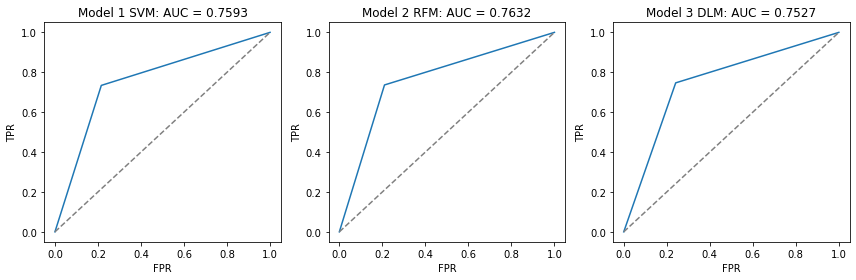

In [61]:
#plot roc_curve for each model
fig, ax = plt.subplots(1, 3, figsize = (12,4))

plot_roc(y_test, y_pred_svm, "Model 1 SVM", ax=ax[0])
plot_roc(y_test, y_pred_rf, "Model 2 RFM", ax=ax[1])
plot_roc(y_test, y_pred_nn, "Model 3 DLM", ax=ax[2])

fig.tight_layout()

### Fine-Tuning the DLM - Experiments

#### 3. ii) - (1st Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** Adam<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** ReLu<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** ReLu<br>

> *Output Layer*<br>
**Activation Function:** Tanh

**AUC SCORE:** 0.7487661841804308 [Decrease of ~0.004 from baseline]<br>
**Changes from Baseline:**<br>
Output layer activation function, Sigmoid --> Tanh<br>
**Result:**<br>
Decrease in AUC as compared to baseline. Better to use Sigmoid rather than Tanh as the output layer activation function.

In [66]:
# Create the Sequential model instance for 1st Trial
nn_t1 = Sequential()

# Add the first hidden layer
nn_t1.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Add the second hidden layer
nn_t1.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t1.add(Dense(units = number_output_neurons, activation = "tanh"))

# Display the Sequential model summary
nn_t1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 27)                1485      
                                                                 
 dense_13 (Dense)            (None, 14)                392       
                                                                 
 dense_14 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compile the Sequential model
nn_t1.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

In [68]:
# Fit the model using 50 epochs and the training data
nn_t1.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 4s 2ms/step - loss: 1.2549 - accuracy: 0.6049
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6741 - accuracy: 0.6762
Epoch 3/50
626/626 [==============================] - 2s 3ms/step - loss: 0.6011 - accuracy: 0.7254
Epoch 4/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5613 - accuracy: 0.7499
Epoch 5/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5331 - accuracy: 0.7606
Epoch 6/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5266 - accuracy: 0.7620
Epoch 7/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5177 - accuracy: 0.7705
Epoch 8/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5392 - accuracy: 0.7389
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5078 - accuracy: 0.7730
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4954 - accuracy: 0.7768

In [69]:
# Use the testing data to make the model predictions
y_pred_nn_t1 = (nn_t1.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t1[:10]

209/209 [==============================] - 0s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int64)

In [70]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t1 = classification_report(y_test, y_pred_nn_t1)
print(testing_report_nn_t1)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      3540
           1       0.72      0.76      0.74      3137

    accuracy                           0.75      6677
   macro avg       0.75      0.75      0.75      6677
weighted avg       0.75      0.75      0.75      6677



In [71]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t1))

0.7487661841804308

#### 3. iii) - (2nd Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** ReLu<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** ReLu<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7594148751280957 [Increase of ~0.0067 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD<br>
**Result:**<br>
Increase in AUC as compared to baseline. Stochastic Gradient Descent appears to provide a marginal improvement to the AUC over Adam.

In [73]:
# Create the Sequential model instance for 2nd Trial
nn_t2 = Sequential()

# Add the first hidden layer
nn_t2.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Add the second hidden layer
nn_t2.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t2.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 27)                1485      
                                                                 
 dense_19 (Dense)            (None, 14)                392       
                                                                 
 dense_20 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Compile the Sequential model
nn_t2.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [75]:
# Fit the model using 50 epochs and the training data
nn_t2.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 2s 2ms/step - loss: 0.6101 - accuracy: 0.6667
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5270 - accuracy: 0.7474
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5025 - accuracy: 0.7660
Epoch 4/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4934 - accuracy: 0.7721
Epoch 5/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4883 - accuracy: 0.7744
Epoch 6/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4845 - accuracy: 0.7768
Epoch 7/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.7778
Epoch 8/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4794 - accuracy: 0.7793
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4776 - accuracy: 0.7810
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4759 - accuracy: 0.7802

In [76]:
# Use the testing data to make the model predictions
y_pred_nn_t2 = (nn_t2.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t2[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [77]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t2 = classification_report(y_test, y_pred_nn_t2)
print(testing_report_nn_t2)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      3540
           1       0.75      0.74      0.74      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [78]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t2))

0.7594148751280957

#### 3. iv) - (3rd Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** RMSprop<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** ReLu<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** ReLu<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.747782436348377 [Decrease of ~0.005 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> RMSprop<br>
**Result:**<br>
Decrease in AUC as compared to baseline. SGD still the best optimizer function.

In [80]:
# Create the Sequential model instance for 3rd Trial
nn_t3 = Sequential()

# Add the first hidden layer
nn_t3.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Add the second hidden layer
nn_t3.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t3.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 27)                1485      
                                                                 
 dense_25 (Dense)            (None, 14)                392       
                                                                 
 dense_26 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Compile the Sequential model
nn_t3.compile(loss = "binary_crossentropy", optimizer = "RMSprop", metrics =["accuracy"])

In [82]:
# Fit the model using 50 epochs and the training data
nn_t3.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 3s 2ms/step - loss: 0.5431 - accuracy: 0.7312
Epoch 2/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4856 - accuracy: 0.7770
Epoch 3/50
626/626 [==============================] - 2s 2ms/step - loss: 0.4759 - accuracy: 0.7805
Epoch 4/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4703 - accuracy: 0.7844
Epoch 5/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4667 - accuracy: 0.7865
Epoch 6/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4633 - accuracy: 0.7890
Epoch 7/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4609 - accuracy: 0.7899
Epoch 8/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4584 - accuracy: 0.7905
Epoch 9/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4568 - accuracy: 0.7925
Epoch 10/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4543 - accuracy: 0.7933

In [83]:
# Use the testing data to make the model predictions
y_pred_nn_t3 = (nn_t3.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t3[:10]

209/209 [==============================] - 0s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [84]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t3 = classification_report(y_test, y_pred_nn_t3)
print(testing_report_nn_t3)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      3540
           1       0.73      0.74      0.73      3137

    accuracy                           0.75      6677
   macro avg       0.75      0.75      0.75      6677
weighted avg       0.75      0.75      0.75      6677



In [85]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t3))

0.747782436348377

#### 3. v) - (4th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** Adagrad<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** ReLu<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** ReLu<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7519261178318196 [Decrease of ~0.0008 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> Adagrad<br>
**Result:**<br>
A slight decrease in AUC as compared to baseline. SGD still preferable to Adam.

In [86]:
# Create the Sequential model instance for 4th Trial
nn_t4 = Sequential()

# Add the first hidden layer
nn_t4.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

# Add the second hidden layer
nn_t4.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t4.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 27)                1485      
                                                                 
 dense_28 (Dense)            (None, 14)                392       
                                                                 
 dense_29 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [87]:
# Compile the Sequential model
nn_t4.compile(loss = "binary_crossentropy", optimizer = "Adagrad", metrics =["accuracy"])

In [88]:
# Fit the model using 50 epochs and the training data
nn_t4.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 3s 2ms/step - loss: 0.7041 - accuracy: 0.5545
Epoch 2/50
626/626 [==============================] - 2s 3ms/step - loss: 0.6616 - accuracy: 0.6172
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6501
Epoch 4/50
626/626 [==============================] - 2s 3ms/step - loss: 0.6207 - accuracy: 0.6693
Epoch 5/50
626/626 [==============================] - 2s 3ms/step - loss: 0.6072 - accuracy: 0.6837
Epoch 6/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5962 - accuracy: 0.6958
Epoch 7/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5868 - accuracy: 0.7043
Epoch 8/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5786 - accuracy: 0.7121
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5714 - accuracy: 0.7181
Epoch 10/50
626/626 [==============================] - 2s 3ms/step - loss: 0.5651 - accuracy: 0.7233

In [89]:
# Use the testing data to make the model predictions
y_pred_nn_t4 = (nn_t4.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t4[:10]

209/209 [==============================] - 1s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [90]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t4 = classification_report(y_test, y_pred_nn_t4)
print(testing_report_nn_t4)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3540
           1       0.75      0.71      0.73      3137

    accuracy                           0.75      6677
   macro avg       0.75      0.75      0.75      6677
weighted avg       0.75      0.75      0.75      6677



In [91]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t4))

0.7519261178318196

#### 3. vi) - (5th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7619533308479619 [Increase of ~0.0092 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid<br>
**Result:**<br>
Highest AUC so far.<br>
Replacing layer 1 & 2 activation functions to sigmoid from ReLu while keeping the optimizer as SGD proves more effective than the baseline for improving model precision.

In [105]:
# Create the Sequential model instance for 5th Trial
nn_t5 = Sequential()

# Add the first hidden layer
nn_t5.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the second hidden layer
nn_t5.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t5.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 27)                1485      
                                                                 
 dense_37 (Dense)            (None, 14)                392       
                                                                 
 dense_38 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Compile the Sequential model
nn_t5.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [107]:
# Fit the model using 50 epochs and the training data
nn_t5.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 4s 2ms/step - loss: 0.6924 - accuracy: 0.5417
Epoch 2/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6772 - accuracy: 0.5654
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6669 - accuracy: 0.6122
Epoch 4/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6528 - accuracy: 0.6646
Epoch 5/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6332 - accuracy: 0.7019
Epoch 6/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6071 - accuracy: 0.7301
Epoch 7/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5768 - accuracy: 0.7448
Epoch 8/50
626/626 [==============================] - 1s 1ms/step - loss: 0.5476 - accuracy: 0.7541
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7622
Epoch 10/50
626/626 [==============================] - 1s 1ms/step - loss: 0.5074 - accuracy: 0.7676

In [108]:
# Use the testing data to make the model predictions
y_pred_nn_t5 = (nn_t5.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t5[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [109]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t5 = classification_report(y_test, y_pred_nn_t5)
print(testing_report_nn_t5)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3540
           1       0.75      0.74      0.75      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [110]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t5))

0.7619533308479619

#### 3. vii) - (6th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Softmax

**AUC SCORE:** 0.5 [Decrease of ~0.2527 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Softmax<br>
**Result:**<br>
Lowest AUC thus far. Softmax not a suitable activation function for the output layer.

In [111]:
# Create the Sequential model instance for 6th Trial
nn_t6 = Sequential()

# Add the first hidden layer
nn_t6.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the second hidden layer
nn_t6.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t6.add(Dense(units = number_output_neurons, activation = "softmax"))

# Display the Sequential model summary
nn_t6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 27)                1485      
                                                                 
 dense_40 (Dense)            (None, 14)                392       
                                                                 
 dense_41 (Dense)            (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Compile the Sequential model
nn_t6.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [114]:
# Fit the model using 50 epochs and the training data
nn_t6.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 2s 2ms/step - loss: 0.6950 - accuracy: 0.4642
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.4642
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6621 - accuracy: 0.4642
Epoch 4/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6414 - accuracy: 0.4642
Epoch 5/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6149 - accuracy: 0.4642
Epoch 6/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5842 - accuracy: 0.4642
Epoch 7/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.4642
Epoch 8/50
626/626 [==============================] - 1s 1ms/step - loss: 0.5288 - accuracy: 0.4642
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.5105 - accuracy: 0.4642
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 0.4983 - accuracy: 0.4642

In [115]:
# Use the testing data to make the model predictions
y_pred_nn_t6 = (nn_t6.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t6[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [116]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t6 = classification_report(y_test, y_pred_nn_t6)
print(testing_report_nn_t6)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3540
           1       0.47      1.00      0.64      3137

    accuracy                           0.47      6677
   macro avg       0.23      0.50      0.32      6677
weighted avg       0.22      0.47      0.30      6677



In [117]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t6))

0.5

#### 3. viii) - (7th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 50<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>

> *Layer 3*<br>
**Hidden Nodes:** 7<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7639905249716794 [Increase of ~0.0112 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid;<br>
Addition of hidden layer 3, containing 7 neurons & Sigmoid activation function<br>
**Result:**<br>
Highest AUC score thus far. Adding a third layer of neurons establishes a more capable model.

In [118]:
# Define the number of hidden nodes for the third hidden layer
hidden_nodes_layer3 = (hidden_nodes_layer2 + 1)//2

# Review the number hidden nodes in the third layer
hidden_nodes_layer3

7

In [119]:
# Create the Sequential model instance for 7th Trial
nn_t7 = Sequential()

# Add the first hidden layer
nn_t7.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the second hidden layer
nn_t7.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the third hidden layer
nn_t7.add(Dense(units = hidden_nodes_layer3, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t7.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t7.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 27)                1485      
                                                                 
 dense_43 (Dense)            (None, 14)                392       
                                                                 
 dense_44 (Dense)            (None, 7)                 105       
                                                                 
 dense_45 (Dense)            (None, 1)                 8         
                                                                 
Total params: 1,990
Trainable params: 1,990
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Compile the Sequential model
nn_t7.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [121]:
# Fit the model using 50 epochs and the training data
nn_t7.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 2s 2ms/step - loss: 0.6954 - accuracy: 0.5152
Epoch 2/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.5358
Epoch 3/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.5358
Epoch 4/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6913 - accuracy: 0.5358
Epoch 5/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6906 - accuracy: 0.5358
Epoch 6/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6902 - accuracy: 0.5358
Epoch 7/50
626/626 [==============================] - 1s 1ms/step - loss: 0.6896 - accuracy: 0.5358
Epoch 8/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6890 - accuracy: 0.5358
Epoch 9/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6883 - accuracy: 0.5358
Epoch 10/50
626/626 [==============================] - 1s 2ms/step - loss: 0.6877 - accuracy: 0.5358

In [122]:
# Use the testing data to make the model predictions
y_pred_nn_t7 = (nn_t7.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t7[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [123]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t7 = classification_report(y_test, y_pred_nn_t7)
print(testing_report_nn_t7)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3540
           1       0.75      0.75      0.75      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [124]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t7))

0.7639905249716794

#### 3. ix) - (8th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 100<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>

> *Layer 3*<br>
**Hidden Nodes:** 7<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7638738205741928 [Increase of ~0.0111 from baseline, however decrease of ~0.0001 from Trial 7]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid;<br>
Addition of hidden layer 3, containing 7 neurons & Sigmoid activation function;<br>
Epochs, 50 --> 100<br>
**Result:**<br>
While the AUC has returned as higher than the baseline, the score is still less than the highest achieved in trial 7 despite the increase in epochs from 50 to 100.<br>
Improvements in accuracy after each epoch were discontinued approximately after epoch 50, meaning greater than 50 epochs is unnecessary for this model configuration.<br>

In [125]:
# Create the Sequential model instance for 8th Trial
nn_t8 = Sequential()

# Add the first hidden layer
nn_t8.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the second hidden layer
nn_t8.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the third hidden layer
nn_t8.add(Dense(units = hidden_nodes_layer3, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t8.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t8.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 27)                1485      
                                                                 
 dense_47 (Dense)            (None, 14)                392       
                                                                 
 dense_48 (Dense)            (None, 7)                 105       
                                                                 
 dense_49 (Dense)            (None, 1)                 8         
                                                                 
Total params: 1,990
Trainable params: 1,990
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the Sequential model
nn_t8.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [127]:
# Fit the model using 50 epochs and the training data
nn_t8.fit(X_train_scaled, y_train, epochs = 100)

Epoch 1/100
626/626 [==============================] - 2s 2ms/step - loss: 0.6896 - accuracy: 0.5359
Epoch 2/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6882 - accuracy: 0.5358
Epoch 3/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6868 - accuracy: 0.5358
Epoch 4/100
626/626 [==============================] - 1s 1ms/step - loss: 0.6853 - accuracy: 0.5359
Epoch 5/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6834 - accuracy: 0.5379
Epoch 6/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6813 - accuracy: 0.5423
Epoch 7/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6785 - accuracy: 0.5475
Epoch 8/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6749 - accuracy: 0.5582
Epoch 9/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6701 - accuracy: 0.5868
Epoch 10/100
626/626 [==============================] - 1s 2ms/step - loss: 0.6637 - accura

In [128]:
# Use the testing data to make the model predictions
y_pred_nn_t8 = (nn_t8.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t8[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [129]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t8 = classification_report(y_test, y_pred_nn_t8)
print(testing_report_nn_t8)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3540
           1       0.75      0.74      0.75      3137

    accuracy                           0.77      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.77      0.76      6677



In [130]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t8))

0.7638738205741928

#### 3. x) - (9th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 500<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.5<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Layer 3*<br>
**Hidden Nodes:** 7<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7640047528226074 [Increase of ~0.0113 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid;<br>
Addition of hidden layer 3, containing 7 neurons & Sigmoid activation function;<br>
Epochs, 50 --> 500<br>
Addition of dropout technique to prevent overfitting, with rate of 0.5 for input layer and 0.2 for layers 2 and 3.<br>
**Result:**<br>
Highest AUC score thus far. Epochs were increased to 500 to gauge the taper-off point for the increases to the model's accuracy following each epoch.<br>
150 epochs appears to the the point at which accuracy begins to fluctuate around approximately 76%. Epochs will thus be altered to 150 for the next test.

In [161]:
# Create the Sequential model instance for 9th Trial
nn_t9 = Sequential()

# Add the first hidden layer
nn_t9.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the first dropout layer
nn_t9.add(Dropout(0.5))

# Add the second hidden layer
nn_t9.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the second dropout layer
nn_t9.add(Dropout(0.2))

# Add the third hidden layer
nn_t9.add(Dense(units = hidden_nodes_layer3, activation = "sigmoid"))

# Add the third dropout layer
nn_t9.add(Dropout(0.2))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t9.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t9.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 27)                1485      
                                                                 
 dropout_3 (Dropout)         (None, 27)                0         
                                                                 
 dense_55 (Dense)            (None, 14)                392       
                                                                 
 dropout_4 (Dropout)         (None, 14)                0         
                                                                 
 dense_56 (Dense)            (None, 7)                 105       
                                                                 
 dropout_5 (Dropout)         (None, 7)                 0         
                                                                 
 dense_57 (Dense)            (None, 1)               

In [162]:
# Compile the Sequential model
nn_t9.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [163]:
# Fit the model using 50 epochs and the training data
nn_t9.fit(X_train_scaled, y_train, epochs = 500)

Epoch 1/500
626/626 [==============================] - 2s 2ms/step - loss: 0.7103 - accuracy: 0.5010
Epoch 2/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6969 - accuracy: 0.5203
Epoch 3/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.5220
Epoch 4/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6945 - accuracy: 0.5249
Epoch 5/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5272
Epoch 6/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.5252
Epoch 7/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6910 - accuracy: 0.5352
Epoch 8/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6916 - accuracy: 0.5313
Epoch 9/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5330
Epoch 10/500
626/626 [==============================] - 1s 2ms/step - loss: 0.6911 - accura

In [164]:
# Use the testing data to make the model predictions
y_pred_nn_t9 = (nn_t9.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t9[:10]

209/209 [==============================] - 0s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [165]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t9 = classification_report(y_test, y_pred_nn_t9)
print(testing_report_nn_t9)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3540
           1       0.75      0.75      0.75      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [166]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t9))

0.7640047528226074

#### 3. xi) - (10th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 150<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.5<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Layer 3*<br>
**Hidden Nodes:** 7<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Layer 4*<br>
**Hidden Nodes:** 4<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7645604494560099 [Increase of ~0.0118 from baseline]<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid;<br>
Addition of hidden layer 3, containing 7 neurons & Sigmoid activation function;<br>
Addition of hidden layer 4, containing 4 neurons & Sigmoid activation function; <br>
Epochs, 50 --> 150<br>
Addition of dropout technique to prevent overfitting, with rate of 0.5 for input layer and 0.2 for layers 2 and 3 (no dropout for layer 4).<br>
**Result:**<br>
An even higher AUC score than the last test. Epochs were altered to 150 and a 4th hidden layer was added to the model.<br>
No dropout layer was added after the fourth hidden layer as testing showed that doing so greatly decreased the model's ability to generate valuable predictions.<br>
Doing so reduced the AUC score to 0.5 (by setting dropout rate for layer 4 to 0.2).

In [167]:
# Define the number of hidden nodes for the fourth hidden layer
hidden_nodes_layer4 = (hidden_nodes_layer3 + 1)//2

# Review the number hidden nodes in the third layer
hidden_nodes_layer4

4

In [174]:
# Create the Sequential model instance for 10th Trial
nn_t10 = Sequential()

# Add the first hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the first dropout layer
nn_t10.add(Dropout(0.5))

# Add the second hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the second dropout layer
nn_t10.add(Dropout(0.2))

# Add the third hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer3, activation = "sigmoid"))

# Add the third dropout layer
nn_t10.add(Dropout(0.2))

# Add the fourth hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer4, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t10.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t10.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 27)                1485      
                                                                 
 dropout_10 (Dropout)        (None, 27)                0         
                                                                 
 dense_64 (Dense)            (None, 14)                392       
                                                                 
 dropout_11 (Dropout)        (None, 14)                0         
                                                                 
 dense_65 (Dense)            (None, 7)                 105       
                                                                 
 dropout_12 (Dropout)        (None, 7)                 0         
                                                                 
 dense_66 (Dense)            (None, 4)               

In [175]:
# Compile the Sequential model
nn_t10.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [176]:
# Fit the model using 50 epochs and the training data
nn_t10.fit(X_train_scaled, y_train, epochs = 150)

Epoch 1/150
626/626 [==============================] - 2s 2ms/step - loss: 0.7165 - accuracy: 0.5358
Epoch 2/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6913 - accuracy: 0.5359
Epoch 3/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6916 - accuracy: 0.5360
Epoch 4/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6913 - accuracy: 0.5350
Epoch 5/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5356
Epoch 6/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.5349
Epoch 7/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6911 - accuracy: 0.5349
Epoch 8/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6912 - accuracy: 0.5361
Epoch 9/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6903 - accuracy: 0.5359
Epoch 10/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6908 - accura

In [177]:
# Use the testing data to make the model predictions
y_pred_nn_t10 = (nn_t10.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t10[:10]

209/209 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [178]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t10 = classification_report(y_test, y_pred_nn_t10)
print(testing_report_nn_t10)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      3540
           1       0.76      0.73      0.75      3137

    accuracy                           0.77      6677
   macro avg       0.77      0.76      0.77      6677
weighted avg       0.77      0.77      0.77      6677



In [179]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t10))

0.7645604494560099

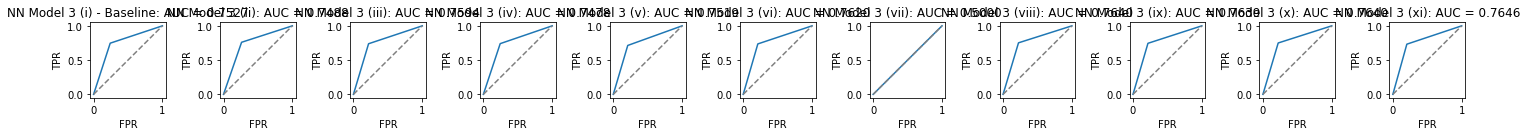

In [192]:
# #plot roc_curves for all neural network test models
# fig, ax = plt.subplots(1, 11, figsize = (20,2))

# plot_roc(y_test, y_pred_nn, "NN Model 3 (i) - Baseline", ax=ax[0])
# plot_roc(y_test, y_pred_nn_t1, "NN Model 3 (ii)", ax=ax[1])
# plot_roc(y_test, y_pred_nn_t2, "NN Model 3 (iii)", ax=ax[2])
# plot_roc(y_test, y_pred_nn_t3, "NN Model 3 (iv)", ax=ax[3])
# plot_roc(y_test, y_pred_nn_t4, "NN Model 3 (v)", ax=ax[4])
# plot_roc(y_test, y_pred_nn_t5, "NN Model 3 (vi)", ax=ax[5])
# plot_roc(y_test, y_pred_nn_t6, "NN Model 3 (vii)", ax=ax[6])
# plot_roc(y_test, y_pred_nn_t7, "NN Model 3 (viii)", ax=ax[7])
# plot_roc(y_test, y_pred_nn_t8, "NN Model 3 (ix)", ax=ax[8])
# plot_roc(y_test, y_pred_nn_t9, "NN Model 3 (x)", ax=ax[9])
# plot_roc(y_test, y_pred_nn_t10, "NN Model 3 (xi)", ax=ax[10])

# fig.tight_layout()